In [37]:
import pandas as pd
import numpy as np
import plotly.express as px
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

In [38]:
dataset_path = r'./datasus/part-00000-0b7ee8fc-4d40-4b71-bec3-5d9ddbf54ec9.c000.csv'
datasus_df = pd.read_csv(dataset_path, sep=';')

C:\Users\Quest\AppData\Local\Temp\ipykernel_19160\1994711914.py:2: DtypeWarning:

Columns (12,26,31,33,34,37,61,62) have mixed types. Specify dtype option on import or set low_memory=False.



# Verificando informações gerais sobre o dataset

In [39]:
datasus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146555 entries, 0 to 146554
Data columns (total 64 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   sintomas                           146553 non-null  object 
 1   profissionalSaude                  146553 non-null  object 
 2   racaCor                            146529 non-null  object 
 3   outrosSintomas                     36211 non-null   object 
 4   outrasCondicoes                    5405 non-null    object 
 5   profissionalSeguranca              146407 non-null  object 
 6   cbo                                5470 non-null    object 
 7   condicoes                          15193 non-null   object 
 8   sexo                               146555 non-null  object 
 9   estado                             146555 non-null  object 
 10  estadoIBGE                         142722 non-null  object 
 11  municipio                          1465

In [40]:
datasus_df.describe()

,municipioNotificacaoIBGE,codigoEstrategiaCovid,codigoBuscaAtivaAssintomatico,codigoTriagemPopulacaoEspecifica,codigoLocalRealizacaoTestagem,codigoEstadoTeste1,codigoTipoTeste1,codigoFabricanteTeste1,codigoResultadoTeste1,codigoEstadoTeste2,...,codigoResultadoTeste2,codigoEstadoTeste3,codigoTipoTeste3,codigoFabricanteTeste3,codigoResultadoTeste3,codigoEstadoTeste4,codigoTipoTeste4,codigoFabricanteTeste4,codigoResultadoTeste4,idade
count,1.404580e+05,141025.000000,9227.000000,2667.000000,141017.000000,112478.000000,112460.000000,67122.000000,87499.000000,4879.000000,...,3390.000000,313.000000,313.000000,156.000000,272.000000,86.000000,86.000000,41.000000,74.000000,112501.000000
mean,2.921072e+06,1.102627,2.757993,4.360330,1.342859,2.996417,2.652134,844.161080,1.757712,2.864111,...,1.757817,2.856230,2.757188,799.730769,1.750000,2.872093,2.744186,761.707317,1.770270,26.468031
std,2.521214e+04,0.360049,1.254716,1.284789,1.333607,0.569171,0.931397,82.349766,0.433219,0.739683,...,0.449309,0.600562,1.464917,134.220298,0.450502,0.548721,1.602836,187.566287,0.454725,16.060907
min,1.600600e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,91.000000,1.000000,1.000000,1.000000,91.000000,1.000000,0.000000
25%,2.913903e+06,1.000000,2.000000,5.000000,1.000000,3.000000,3.000000,792.000000,2.000000,3.000000,...,1.000000,3.000000,1.000000,715.000000,1.000000,3.000000,1.000000,715.000000,2.000000,13.000000
50%,2.927408e+06,1.000000,2.000000,5.000000,1.000000,3.000000,3.000000,915.000000,2.000000,3.000000,...,2.000000,3.000000,3.000000,792.000000,2.000000,3.000000,3.000000,792.000000,2.000000,28.000000
75%,2.927408e+06,1.000000,4.000000,5.000000,1.000000,3.000000,3.000000,915.000000,2.000000,3.000000,...,2.000000,3.000000,3.000000,915.000000,2.000000,3.000000,3.000000,915.000000,2.000000,40.000000
max,2.933604e+06,3.000000,4.000000,5.000000,7.000000,4.000000,9.000000,915.000000,3.000000,4.000000,...,3.000000,4.000000,9.000000,915.000000,3.000000,4.000000,9.000000,915.000000,3.000000,54.000000


In [41]:
datasus_df['classificacaoFinal'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 146555 entries, 0 to 146554
Series name: classificacaoFinal
Non-Null Count  Dtype 
--------------  ----- 
93379 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


# Verificação de valores nulos

<Axes: >

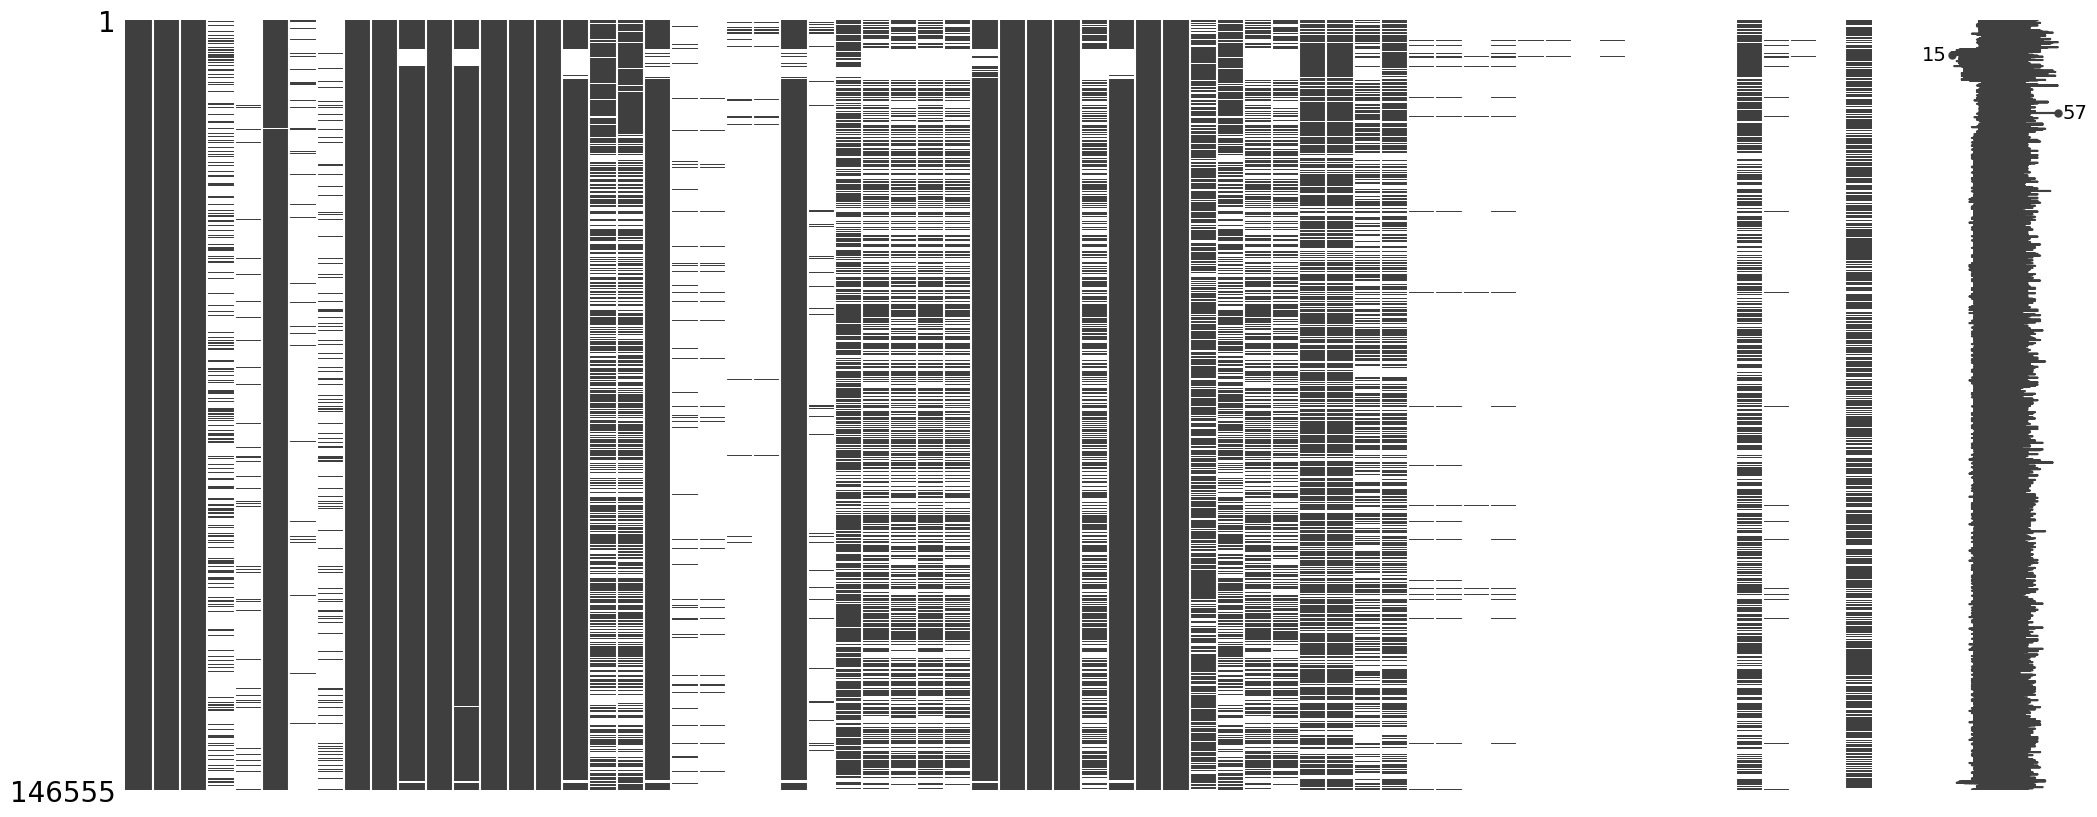

In [42]:
msno.matrix(datasus_df)

# Conferindo features categóricas e numéricas

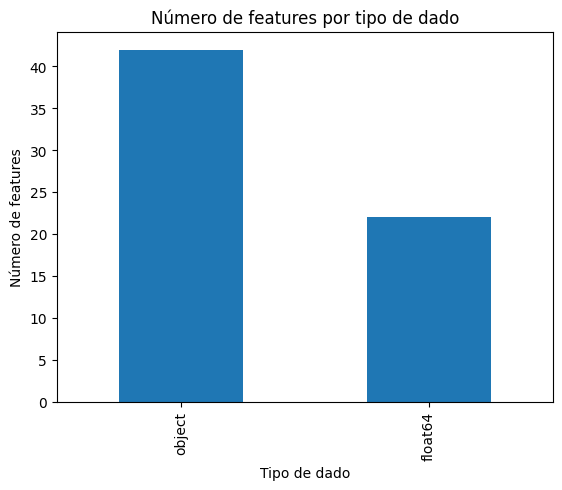

In [43]:
fig, ax = plt.subplots()
datasus_df.dtypes.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Número de features por tipo de dado')
ax.set_xlabel('Tipo de dado')
ax.set_ylabel('Número de features')
plt.show()

# Analisando imbalanceamento da feature alvo

In [44]:
datasus_df.dropna(subset=['classificacaoFinal'], inplace=True)

In [45]:
datasus_df['classificacaoFinal'].value_counts()

classificacaoFinal
Descartado                           41639
Síndrome Gripal Não Especificada     31442
Confirmado Laboratorial              16891
Confirmado Clínico-Epidemiológico     2896
Confirmado por Critério Clínico        473
Confirmado Clínico-Imagem               38
Name: count, dtype: int64

# Lidando com a coluna "Sintomas"

In [46]:
datasus_df['listaSintomas'] = datasus_df['sintomas'].str.split(',')
datasus_df.dropna(subset=['listaSintomas'], inplace=True)
datasus_df['listaSintomas'] = datasus_df['listaSintomas'].apply(lambda x: [s.lower().strip() for s in x])
datasus_df['idPaciente'] = datasus_df.index
sintomas_df = datasus_df.explode('listaSintomas')
encoded_df = pd.get_dummies(sintomas_df['listaSintomas'])
agrupado_df = sintomas_df[['idPaciente']].join(encoded_df).groupby('idPaciente').max()
resultado_df = pd.merge(datasus_df.drop(columns=['listaSintomas']), agrupado_df, left_index=True, right_index=True)
resultado_df.drop(columns=['', 'sintomas'], inplace=True)

# Lidando com a coluna "Outros Sintomas"
A coluna "outrosSintomas" necessita do mesmo tratamento que a coluna "sintomas", mas para propósitos de economia computacional, vamos dropar ela por hora

In [47]:
resultado_df.drop(columns=['outrosSintomas', 'outrasCondicoes'], inplace=True)

In [48]:
resultado_df.nunique().sort_values(ascending=False)

source_id                93377
idPaciente               93377
dataInicioSintomas        1541
dataColetaTeste1          1516
dataNotificacao           1514
                         ...  
dor de cabeça                2
outros                       2
tosse                        2
estadoNotificacaoIBGE        1
estadoNotificacao            1
Length: 73, dtype: int64

# Dropando colunas insignificantes

## Colunas de data

In [49]:
resultado_df.drop(columns=resultado_df.filter(like='data').columns, inplace=True)
resultado_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93377 entries, 0 to 146554
Data columns (total 64 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   profissionalSaude                  93377 non-null  object 
 1   racaCor                            93353 non-null  object 
 2   profissionalSeguranca              93277 non-null  object 
 3   cbo                                3654 non-null   object 
 4   condicoes                          8046 non-null   object 
 5   sexo                               93377 non-null  object 
 6   estado                             93377 non-null  object 
 7   estadoIBGE                         89566 non-null  object 
 8   municipio                          93377 non-null  object 
 9   municipioIBGE                      89509 non-null  object 
 10  origem                             93375 non-null  object 
 11  estadoNotificacao                  93377 non-null  object 

## Coluna "source_id"

In [50]:
resultado_df.drop(columns=['source_id'], inplace=True)

## Colunas de códigos
Muitas das colunas que possuem "código" no nome estão como tipo float64, quando na verdade são códigos únicos e categóricos

In [51]:
resultado_df[resultado_df.select_dtypes(include=['float64']).columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 93377 entries, 0 to 146554
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   municipioNotificacaoIBGE          87388 non-null  float64
 1   codigoEstrategiaCovid             87947 non-null  float64
 2   codigoBuscaAtivaAssintomatico     5929 non-null   float64
 3   codigoTriagemPopulacaoEspecifica  2201 non-null   float64
 4   codigoLocalRealizacaoTestagem     87937 non-null  float64
 5   codigoEstadoTeste1                77182 non-null  float64
 6   codigoTipoTeste1                  77164 non-null  float64
 7   codigoFabricanteTeste1            45031 non-null  float64
 8   codigoResultadoTeste1             61094 non-null  float64
 9   codigoEstadoTeste2                4166 non-null   float64
 10  codigoTipoTeste2                  4166 non-null   float64
 11  codigoFabricanteTeste2            1516 non-null   float64
 12  codigoRe

In [52]:
resultado_df[resultado_df.filter(like='codigo').columns] = resultado_df.filter(like='codigo').astype('category')
resultado_df[resultado_df.filter(like='codigo').columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 93377 entries, 0 to 146554
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   codigoEstrategiaCovid              87947 non-null  category
 1   codigoBuscaAtivaAssintomatico      5929 non-null   category
 2   codigoTriagemPopulacaoEspecifica   2201 non-null   category
 3   codigoLocalRealizacaoTestagem      87937 non-null  category
 4   codigoRecebeuVacina                69752 non-null  category
 5   codigoLaboratorioPrimeiraDose      49934 non-null  category
 6   codigoLaboratorioSegundaDose       44912 non-null  category
 7   codigoContemComunidadeTradicional  89524 non-null  category
 8   codigoDosesVacina                  52979 non-null  category
 9   codigoEstadoTeste1                 77182 non-null  category
 10  codigoTipoTeste1                   77164 non-null  category
 11  codigoFabricanteTeste1             45031 non-

In [53]:
resultado_df[resultado_df.filter(like='codigo').columns].nunique().sort_values(ascending=False)

codigoDosesVacina                    16
codigoLaboratorioPrimeiraDose        15
codigoFabricanteTeste1               15
codigoLaboratorioSegundaDose         14
codigoFabricanteTeste3               10
codigoTipoTeste1                      9
codigoTipoTeste3                      9
codigoTipoTeste2                      8
codigoFabricanteTeste2                8
codigoLocalRealizacaoTestagem         7
codigoTipoTeste4                      6
codigoFabricanteTeste4                6
codigoTriagemPopulacaoEspecifica      5
codigoRecebeuVacina                   5
codigoEstadoTeste4                    4
codigoBuscaAtivaAssintomatico         4
codigoContemComunidadeTradicional     4
codigoEstadoTeste1                    4
codigoEstadoTeste3                    4
codigoEstadoTeste2                    4
codigoEstrategiaCovid                 3
codigoResultadoTeste2                 3
codigoResultadoTeste1                 3
codigoResultadoTeste3                 3
codigoResultadoTeste4                 3


# Tratando colunas categóricas do tipo "object"

In [54]:
resultado_df.select_dtypes(include=['object']).columns

Index(['profissionalSaude', 'racaCor', 'profissionalSeguranca', 'cbo',
       'condicoes', 'sexo', 'estado', 'estadoIBGE', 'municipio',
       'municipioIBGE', 'origem', 'estadoNotificacao', 'municipioNotificacao',
       'evolucaoCaso', 'classificacaoFinal', 'outroBuscaAtivaAssintomatico',
       'outroTriagemPopulacaoEspecifica', 'outroLocalRealizacaoTestagem',
       'lotePrimeiraDose', 'loteSegundaDose', 'excluido', 'validado',
       'estadoNotificacaoIBGE', 'totalTestesRealizados'],
      dtype='object')

In [55]:
resultado_df.select_dtypes(include=['object']).nunique().sort_values(ascending=False)

municipioIBGE                      1121
lotePrimeiraDose                    814
loteSegundaDose                     784
municipio                           739
outroBuscaAtivaAssintomatico        485
municipioNotificacao                322
outroLocalRealizacaoTestagem        297
cbo                                 218
outroTriagemPopulacaoEspecifica     182
condicoes                           158
estadoIBGE                           24
estado                               24
totalTestesRealizados                12
evolucaoCaso                          7
classificacaoFinal                    6
racaCor                               6
sexo                                  2
profissionalSeguranca                 2
profissionalSaude                     2
origem                                2
validado                              2
excluido                              2
estadoNotificacao                     1
estadoNotificacaoIBGE                 1
dtype: int64

In [56]:
resultado_df.drop(columns=['estadoNotificacao', 'estadoNotificacaoIBGE', 'origem', 'cbo'], inplace=True)

# Tratando a coluna condições
A coluna "condições", assim como a coluna "sintomas", possui strings que determinam as condições, e portanto cada condição listada deve receber sua própria coluna booleana. No entanto, fazer esse tipo de tratamento nos dados implica numa perda de 84000 entries, então o código abaixo foi comentado para ficar como um tratamento opcional para propósitos de treinamento.

In [57]:
resultado_df['condicoes'] = resultado_df['condicoes'].fillna('nenhuma condição')
resultado_df['listaCondicoes'] = datasus_df['condicoes'].str.split(',')
resultado_df.dropna(subset=['listaCondicoes'], inplace=True)
resultado_df['listaCondicoes'] = resultado_df['listaCondicoes'].apply(lambda x: [s.lower().strip() for s in x])
condicoes_df = resultado_df.explode('listaCondicoes')
encoded_df = pd.DataFrame()
encoded_df = pd.get_dummies(condicoes_df['listaCondicoes'])
agrupado_df = pd.DataFrame()
agrupado_df = condicoes_df[['idPaciente']].join(encoded_df).groupby('idPaciente').max()
resultado_df = pd.merge(resultado_df.drop(columns=['listaCondicoes']), agrupado_df, left_index=True, right_index=True)
resultado_df.drop(columns=['condicoes'], inplace=True)
resultado_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8046 entries, 26 to 146546
Data columns (total 70 columns):
 #   Column                                                                  Non-Null Count  Dtype   
---  ------                                                                  --------------  -----   
 0   profissionalSaude                                                       8046 non-null   object  
 1   racaCor                                                                 8045 non-null   object  
 2   profissionalSeguranca                                                   8038 non-null   object  
 3   sexo                                                                    8046 non-null   object  
 4   estado                                                                  8046 non-null   object  
 5   estadoIBGE                                                              7701 non-null   object  
 6   municipio                                                               80

In [58]:
resultado_df.drop(columns=['4 ou 5)'], inplace=True)

In [59]:
resultado_df.drop(columns=resultado_df.columns[resultado_df.isnull().mean() > 0.9], inplace=True)

In [60]:
resultado_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8046 entries, 26 to 146546
Data columns (total 56 columns):
 #   Column                                                                  Non-Null Count  Dtype   
---  ------                                                                  --------------  -----   
 0   profissionalSaude                                                       8046 non-null   object  
 1   racaCor                                                                 8045 non-null   object  
 2   profissionalSeguranca                                                   8038 non-null   object  
 3   sexo                                                                    8046 non-null   object  
 4   estado                                                                  8046 non-null   object  
 5   estadoIBGE                                                              7701 non-null   object  
 6   municipio                                                               80

In [61]:
for col in resultado_df.columns:
    if resultado_df[col].dtype == 'categorical':
        unique_types = resultado_df[col].map(type).unique()
        print(f"Column '{col}' has the following types: {unique_types}")

In [62]:
resultado_df['municipioIBGE'] = resultado_df['municipioIBGE'].fillna(resultado_df['municipioIBGE'].mode()[0])
resultado_df['municipioIBGE'] = resultado_df['municipioIBGE'].apply(lambda x: resultado_df['municipioIBGE'].mode()[0] if x == 'BA' else x)
resultado_df['municipioIBGE'] = resultado_df['municipioIBGE'].apply(lambda x: int(x) if isinstance(x, float) else x)
resultado_df['municipioIBGE'] = resultado_df['municipioIBGE'].apply(lambda x: str(x) if isinstance(x, int) else x)
resultado_df['municipioIBGE'] = resultado_df['municipioIBGE'].astype('category')
resultado_df['evolucaoCaso'] = resultado_df['evolucaoCaso'].fillna('Nenhum')
resultado_df['outroBuscaAtivaAssintomatico'] = resultado_df['outroBuscaAtivaAssintomatico'].fillna('Nenhum')
resultado_df['lotePrimeiraDose'] = resultado_df['lotePrimeiraDose'].fillna('Nenhum')
resultado_df['loteSegundaDose'] = resultado_df['loteSegundaDose'].fillna('Nenhum')
resultado_df['estadoIBGE'] = resultado_df['estadoIBGE'].fillna(resultado_df['estadoIBGE'].mode()[0])
resultado_df['profissionalSeguranca'] = resultado_df['profissionalSeguranca'].fillna(resultado_df['profissionalSeguranca'].mode()[0])
resultado_df['racaCor'] = resultado_df['racaCor'].fillna(resultado_df['racaCor'].mode()[0])
resultado_df['totalTestesRealizados'] = resultado_df['totalTestesRealizados'].apply(lambda x: int(x) if isinstance(x, str) else x)

for column in resultado_df.filter(like='codigo').columns:
    resultado_df[column] = resultado_df[column].fillna(resultado_df[column].mode()[0])

resultado_df['idade'] = resultado_df['idade'].fillna(resultado_df['idade'].mean())
resultado_df['municipioNotificacaoIBGE'] = resultado_df['municipioNotificacaoIBGE'].fillna(resultado_df['municipioIBGE'])

In [63]:
def converter_para_coluna_bool(df, col):
    df[col] = df[col].apply(lambda x: x.capitalize() if isinstance(x, str) else x)
    df[col] = df[col].map({'False': False, 'True': True})
    df[col] = df[col].astype('bool')

In [64]:
converter_para_coluna_bool(resultado_df, 'excluido')
converter_para_coluna_bool(resultado_df, 'validado')

In [65]:
for column in resultado_df.select_dtypes(include=['object']).columns:
    resultado_df[column] = resultado_df[column].astype('category')

# Solucionando a falta de balanceamento no target "classificacaoFinal"


In [66]:
fig = px.histogram(resultado_df, x='classificacaoFinal', title='Distribuição das classes na variável alvo')
fig.show()

In [68]:
resultado_df['classificacaoFinal'] = resultado_df['classificacaoFinal'].apply(lambda x: 'positivo' if 'confirmado' in x.lower() else x)
resultado_df['classificacaoFinal'] = resultado_df['classificacaoFinal'].apply(lambda x: 'negativo' if 'descartado' in x.lower() else x)

In [69]:
fig = px.histogram(resultado_df, x='classificacaoFinal', title='Distribuição das classes na variável alvo após condensar categorias')
fig.show()

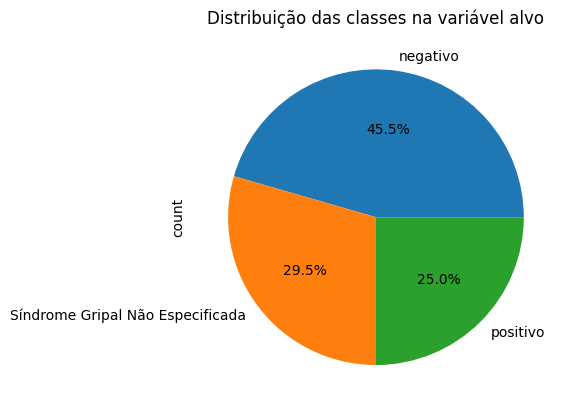

In [70]:
fig, ax = plt.subplots()
resultado_df['classificacaoFinal'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
ax.set_title('Distribuição das classes na variável alvo')
plt.show()

In [71]:
label_encoder = LabelEncoder()
resultado_df['classificacaoFinal'] = label_encoder.fit_transform(resultado_df['classificacaoFinal'])

for column in resultado_df.drop(columns=['classificacaoFinal']).select_dtypes(include=['category']).columns:
    encoded_df = pd.get_dummies(resultado_df[column], prefix=column)
    resultado_df = pd.concat([resultado_df, encoded_df], axis=1)
    resultado_df.drop(columns=[column], inplace=True)

In [87]:
resultado_df.to_csv(r'./datasus/datasus_preprocessed_condensed.csv', index=False)